In [1]:
# Importing the libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras import callbacks

Using TensorFlow backend.


In [3]:
# Some functions to help out with

In [4]:
def plot_predictions(test,predicted):
    plt.plot(test, color='Red', label='Real IBM Stock Price')
    plt.plot(predicted, color='blue', label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

In [5]:
def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test,predicted))
    return ("The root mean squared error is {}.".format(rmse))

In [6]:
# importing dataset

In [7]:
dataset = pd.read_csv("IBM_2006-01-01_to_2018-01-01.csv", index_col="Date", parse_dates=["Date"])

In [8]:
# Visualize datset

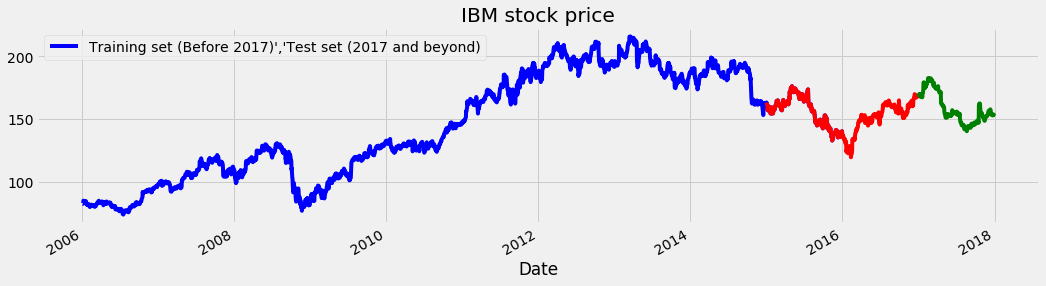

In [9]:
dataset["High"][:"2015"].plot(figsize=(16,4), legend=True, color="blue")
dataset["High"]["2015":"2016"].plot(figsize=(16,4), legend=True, color="red")
dataset["High"]["2017":].plot(figsize=(16,4), legend=True, color="green")
plt.legend(["Training set (Before 2017)','Test set (2017 and beyond)"])
plt.title("IBM stock price")
plt.show()

In [10]:
# creating different dataset

In [11]:
training_set = dataset[:'2015'].iloc[:,1:2].values
validation_set = dataset['2015':'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

In [12]:
# spliting datasets into train, validation, test sets

In [13]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
validation_set_scaled = sc.fit_transform(validation_set)
test_set_scaled = sc.fit_transform(test_set)

In [14]:
# spliting datasets into X and y

In [15]:
X_train = []
y_train = []
X_validation = []
y_validation = []
X_test = []
y_test = []
lengthArr = [len(training_set_scaled), len(validation_set_scaled), len(test_set_scaled)]
for i in range(0,len(lengthArr)):
    for j in range(60, lengthArr[i]):
        if(i == 0):
            X_train.append(training_set_scaled[j-60:j,0])
            y_train.append(training_set_scaled[j,0])
        if(i == 1):
            X_validation.append(validation_set_scaled[j-60:j,0])
            y_validation.append(validation_set_scaled[j,0])
        if(i == 2):
            X_test.append(test_set_scaled[j-60:j,0])
            y_test.append(test_set_scaled[j,0])                
X_train, y_train = np.array(X_train), np.array(y_train)
X_validation, y_validation = np.array(X_validation), np.array(y_validation)
X_test, y_test = np.array(X_test), np.array(y_test)

In [16]:
# Reshaping for efficient modelling

In [17]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
X_validation = np.reshape(X_validation, (X_validation.shape[0],X_validation.shape[1],1))
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [18]:
# Build the LSTM architecture

In [19]:
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)
])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
# Compiling the LSTM

In [21]:
model.compile(optimizer='rmsprop',loss='mean_squared_error')

In [22]:
# Fitting to the training set with callbacks

In [23]:
early_stopping = callbacks.EarlyStopping(patience=50)
model_checkpoint = callbacks.ModelCheckpoint("my_checkpoint.h5", save_best_only=True)

In [24]:
model.fit(X_train,y_train,validation_data=(X_validation,y_validation),epochs=50,batch_size=32, callbacks=[early_stopping, model_checkpoint])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 2457 samples, validate on 444 samples
Epoch 1/50





2457/2457 [==============================] - 38s 15ms/step - loss: 0.0233 - val_loss: 0.0605
Epoch 2/50
2457/2457 [==============================] - 30s 12ms/step - loss: 0.0110 - val_loss: 0.0102
Epoch 3/50
2457/2457 [==============================] - 29s 12ms/step - loss: 0.0089 - val_loss: 0.0106
Epoch 4/50
2457/2457 [==============================] - 28s 11ms/step - loss: 0.0074 - val_loss: 0.0134
Epoch 5/50
2457/2457 [==============================] - 27s 11ms/step - loss: 0.0065 - val_loss: 0.0077
Epoch 6/50
2457/2457 [==============================] - 29s 12ms/step - loss: 0.0059 - val_loss: 0.0102
Epoch 7/50
2457/2457 [==============================] - 29s 12ms/step - loss: 0.0053 - val_loss: 0.0064
Epoch 8/50
2457/2457 [==============================] - 31s 12ms/step - loss: 0.0053 - val_loss: 0.0091
Epoch 9/50
2457/245

In [25]:
# loading checkpoint model

In [26]:
model = load_model("my_checkpoint.h5")

In [27]:
# preparing datset for prediction

In [28]:
dataset_total = pd.concat((dataset["High"][:'2015'],dataset["High"]['2015':'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)
final_test = []
for i in range(60,311):
    final_test.append(inputs[i-60:i,0])
final_test = np.array(final_test)
final_test = np.reshape(final_test, (final_test.shape[0],final_test.shape[1],1))

In [29]:
# Predicting the prices

In [30]:
predicted_stock_price = model.predict(final_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [31]:
# Visualizing the results for LSTM

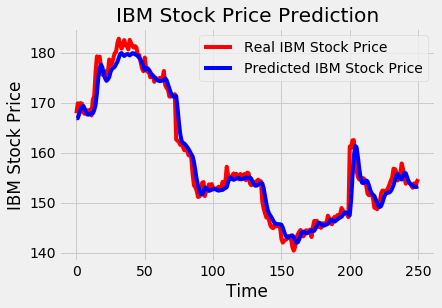

In [32]:
plot_predictions(test_set,predicted_stock_price)

In [33]:
# Evaluating model

In [34]:
return_rmse(test_set,predicted_stock_price)

'The root mean squared error is 2.1757601295107514.'